# Tuberculosis Detection
In this notebook I hope to be able to combine my knowledge thus far and create a model for tuberculosis detection on my own. The dataset is provided by:

Tawsifur Rahman, Amith Khandakar, Muhammad A. Kadir, Khandaker R. Islam, Khandaker F. Islam, Zaid B. Mahbub, Mohamed Arselene Ayari, Muhammad E. H. Chowdhury. (2020) "Reliable Tuberculosis Detection using Chest X-ray with Deep Learning, Segmentation and Visualization". IEEE Access, Vol. 8, pp 191586 - 191601. DOI. 10.1109/ACCESS.2020.3031384.

In [1]:
# Collect Imports here
import os
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import os
image_paths_norm = [os.path.join('./data/TB_Chest_Radiography_Database/Normal', i) for i in os.listdir('./data/TB_Chest_Radiography_Database/Normal') if i.endswith('.png')]
image_paths_tb = [os.path.join('./data/TB_Chest_Radiography_Database/Tuberculosis', i) for i in os.listdir('./data/TB_Chest_Radiography_Database/Tuberculosis') if i.endswith('.png')]

In [3]:
# Let's check the number of images in each class
print('Number of Normal images:', len(image_paths_norm))
print('Number of TB images:', len(image_paths_tb))

Number of Normal images: 3500
Number of TB images: 700


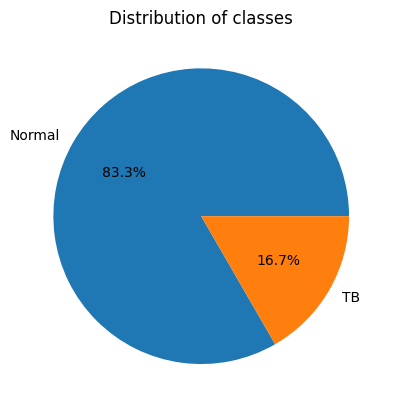

In [4]:
# Plot pie chart
import matplotlib.pyplot as plt
plt.pie([len(image_paths_norm), len(image_paths_tb)], labels=['Normal', 'TB'], autopct='%1.1f%%')
plt.title('Distribution of classes')
plt.show()


This might be problematic as our dataset is heavily skewed at the moment.

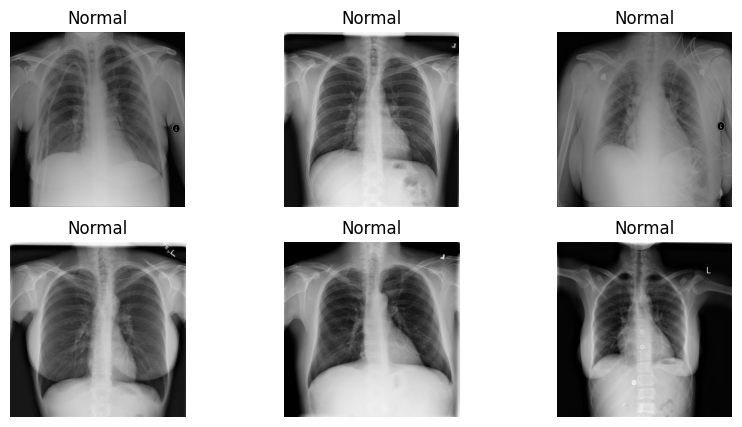

In [5]:
# Let's check the first 10 images in each class
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(10, 5))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(plt.imread(image_paths_norm[i]), cmap='gray')
    ax.set_title('Normal')
    ax.axis('off')
plt.show()

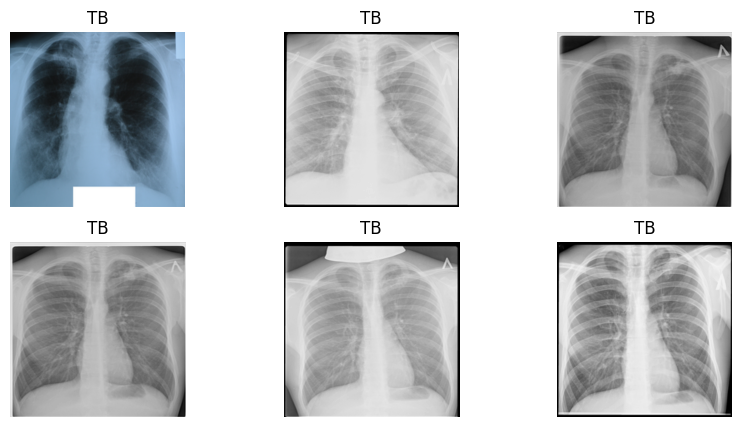

In [6]:
# DO the same for TB images
fig, axes = plt.subplots(2, 3, figsize=(10, 5))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(plt.imread(image_paths_tb[i]), cmap='gray')
    ax.set_title('TB')
    ax.axis('off')
plt.show()

In [7]:
# check the size of the images
for image in image_paths_norm:
    image = plt.imread(image)
    if image.shape != (512, 512, 3):
        print(image+" "+image.shape)
    else:
        pass

All the normal images are the same shape. which is good but either way, I kinda want to use transfer learning based approach so I'm probably gonna have to resize the images depending on the models input channels!

In [8]:
for image_path in image_paths_tb:
    count = 0
    image = plt.imread(image_path)
    while count < 10:
        if image.shape != (512, 512, 3):
            print(image.shape)
            count += 1
        else:
            break  # Exit the loop if the image shape is correct


(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)

As we can see, some our test images are grayscale, and they don't even have a color channel, (we have to expand the dimensions!). We need to keep in mind the following, we want the input feature to be (1, img_height, img_width).

In [9]:
# We now have the image paths and the size of the images. We can now proceed to load the images and preprocess them
# We will resize the images to 224x224 and convert them to grayscale
import cv2
import torch
from torch.utils.data import Dataset

class ChestXRayDataset(Dataset):
    def __init__(self, image_paths, transform=None, train=True):
        self.image_paths = image_paths
        self.transform = transform
        self.train = train
        if self.train:
            self.image_paths = self.image_paths[:int(len(image_paths)*0.8)]
        else:
            self.image_paths = self.image_paths[int(len(image_paths)*0.8):]
    
    def __getitem__(self, index):
        image = cv2.imread(self.image_paths[index], 0)
        image = cv2.resize(image, (224, 224))
        image = np.array(image).astype('float32') / 255
        image = np.expand_dims(image, axis=0)
        image = torch.tensor(image)
        label = 0 if 'Normal' in self.image_paths[index] else 1 # 0 for Normal and 1 for TB
        return image, label
    
    def __len__(self):
        return len(self.image_paths)

In [10]:
image_paths = image_paths_norm + image_paths_tb
shuffled_image_paths = np.random.permutation(image_paths) # Shuffle the image paths
dataset = ChestXRayDataset(shuffled_image_paths)

In [11]:
# check the shape of the images in the dataset
for data in dataset:
    if data[0].shape != (1, 224, 224):
        print(data[0].shape)

I'm going to skip any data augmentation for the moment, we'll revisit this later if needed!

In [12]:
from torch.utils.data import DataLoader

train_dataset = ChestXRayDataset(shuffled_image_paths, train=True)
test_dataset = ChestXRayDataset(shuffled_image_paths, train=False)

# Data Loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [20]:
import torch.nn as nn
class SimpleCNN(nn.Module):
    def __init__(self, input_size=1, num_classes=1):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2) # (1, 224, 224) -> (6, 224, 224)
        self.relu1 = nn.ReLU() # (6, 224, 224)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # (6, 224, 224) -> (6, 112, 112)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(6*112*112, 120)
        self.fc2 = nn.Linear(120, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x


In [21]:
model  = SimpleCNN(input_size=(1, 224, 224), num_classes=2)

In [22]:
from torchsummary import summary
summary(model, (1, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 6, 224, 224]             156
              ReLU-2          [-1, 6, 224, 224]               0
         MaxPool2d-3          [-1, 6, 112, 112]               0
           Flatten-4                [-1, 75264]               0
            Linear-5                  [-1, 120]       9,031,800
            Linear-6                    [-1, 2]             242
Total params: 9,032,198
Trainable params: 9,032,198
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 5.74
Params size (MB): 34.46
Estimated Total Size (MB): 40.39
----------------------------------------------------------------


In [23]:
from torch import optim
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Modify the last layer to have 2 output units
model.fc2 = nn.Linear(120, 2)

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.train()

num_epochs = 5
for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2%}")


Epoch [1/5], Loss: 0.3833, Accuracy: 89.55%
Epoch [2/5], Loss: 0.1015, Accuracy: 96.19%
Epoch [3/5], Loss: 0.0633, Accuracy: 97.83%
Epoch [4/5], Loss: 0.0519, Accuracy: 98.42%
Epoch [5/5], Loss: 0.0328, Accuracy: 99.11%


Bruh, this looks way to good to be true, I just have a feeling that our model is overfitting. Let's hope I'm wrong AHAHAHA

In [39]:
# Evaluation loop
model.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for test_inputs, test_labels in test_loader:
        test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
        
        test_outputs = model(test_inputs)
        _, test_predicted = torch.max(test_outputs, 1)
        test_total += test_labels.size(0)
        test_correct += (test_predicted == test_labels).sum().item()

test_accuracy = test_correct / test_total
print(f"Validation Accuracy: {test_accuracy:.2%}")

Validation Accuracy: 97.26%


Wow not bad, let's see how far we can stretch the accuracy! I'm now going to define a 2nd model that incorporatates a dropout layer to add some regularization to our model architecture

In [34]:
class SimpleCNNV2(nn.Module):
    def __init__(self, input_channels=1, num_classes=2):
        super(SimpleCNNV2, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 6, kernel_size=5, stride=1, padding=2) # (1, 224, 224) -> (6, 224, 224)
        self.relu1 = nn.ReLU() # (6, 224, 224)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # (6, 224, 224) -> (6, 112, 112)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0) # (6, 112, 112) -> (16, 108, 108)
        self.relu2 = nn.ReLU() # (16, 108, 108)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # (16, 108, 108) -> (16, 54, 54)
        self.flatten = nn.Flatten() 
        self.fc1 = nn.Linear(16 * 54 * 54, 120)
        self.relu3 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)  # Add dropout layer with 50% probability
        self.fc2 = nn.Linear(120, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x
        

In [35]:
model_v2 = SimpleCNNV2(input_channels=1, num_classes=2)

In [36]:
import torchsummary as summary
summary.summary(model_v2, (1, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 6, 224, 224]             156
              ReLU-2          [-1, 6, 224, 224]               0
         MaxPool2d-3          [-1, 6, 112, 112]               0
            Conv2d-4         [-1, 16, 108, 108]           2,416
              ReLU-5         [-1, 16, 108, 108]               0
         MaxPool2d-6           [-1, 16, 54, 54]               0
           Flatten-7                [-1, 46656]               0
            Linear-8                  [-1, 120]       5,598,840
              ReLU-9                  [-1, 120]               0
          Dropout-10                  [-1, 120]               0
           Linear-11                    [-1, 2]             242
Total params: 5,601,654
Trainable params: 5,601,654
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forw

In [37]:
from torch import optim
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_v2.parameters(), lr=0.001)

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_v2.to(device)
model_v2.train()

num_epochs = 5
for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model_v2(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2%}")

Epoch [1/5], Loss: 0.3514, Accuracy: 86.04%
Epoch [2/5], Loss: 0.1721, Accuracy: 93.07%
Epoch [3/5], Loss: 0.1404, Accuracy: 94.94%
Epoch [4/5], Loss: 0.0973, Accuracy: 96.90%
Epoch [5/5], Loss: 0.0794, Accuracy: 97.53%


In [38]:
# Evaluation loop
model_v2.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for test_inputs, test_labels in test_loader:
        test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
        
        test_outputs = model_v2(test_inputs)
        _, test_predicted = torch.max(test_outputs, 1)
        test_total += test_labels.size(0)
        test_correct += (test_predicted == test_labels).sum().item()

test_accuracy = test_correct / test_total
print(f"Validation Accuracy: {test_accuracy:.2%}")

Validation Accuracy: 98.93%


OK BACKTRACK, I was being dumb. Actually the model isn't overfitting or underfitting. It's actually doing really good!

So now let's put it to the test on some random chest x-ray online! I googled TB Chest X-Ray and found the image "test_img.jpq", and we'll see if the model is going to get it right

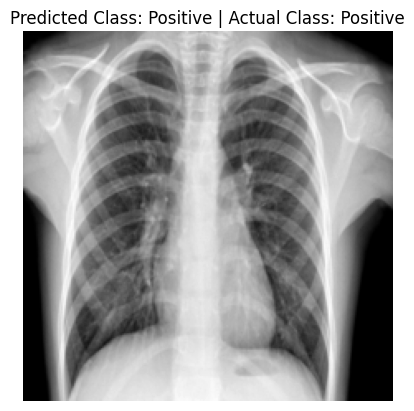

In [62]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

# Choose any image
test_image_path = './data/test_img.jpg'

# Define transformations for the test image
transform = transforms.Compose([
    transforms.Grayscale(),  # Convert to grayscale
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load and preprocess the test image
test_image = Image.open(test_image_path)
test_image = transform(test_image)
test_image = test_image.unsqueeze(0)  # Add a batch dimension since the model expects batches

# Pass the test image through trained model to get predictions
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_v2.eval()  # Set the model to evaluation mode
test_image = test_image.to(device)
with torch.no_grad():
    output = model_v2(test_image)

# Get the predicted class index
_, predicted_class_idx = torch.max(output, 1)
predicted_class_idx = predicted_class_idx.item()

# Define the class labels
class_labels = ['Negative', 'Positive'] # 0 is Negative and 1 is Positive

# Visualize the test image along with the predicted label
plt.imshow(test_image.squeeze().cpu(), cmap='gray')  # Convert the image back to numpy format and remove batch dimension
plt.title(f'Predicted Class: {class_labels[predicted_class_idx]} | Actual Class: {class_labels[1]}')
plt.axis('off')
plt.show()



YASSS IT DID